In [1]:
from turtle import st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, layers, losses
from cmath import pi
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

(39000, 14)
False


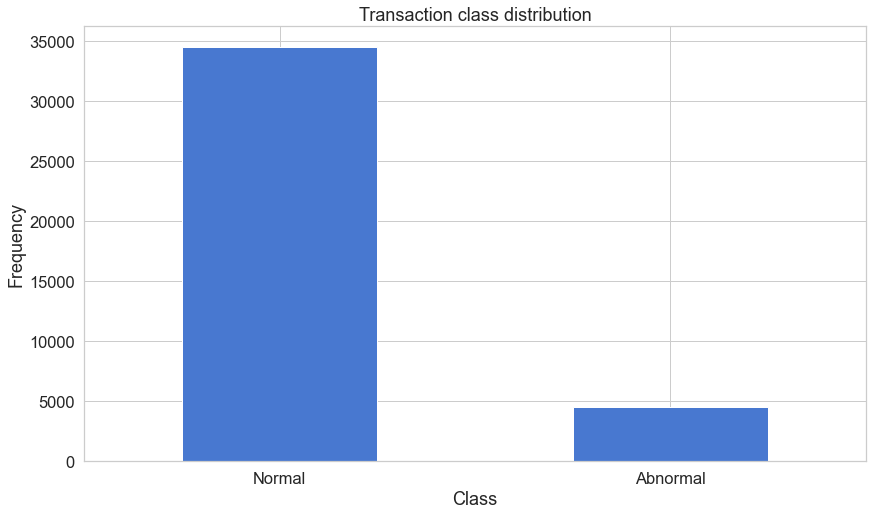

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Abnormal"]


# train data
df = pd.read_csv("Autoencoder1.csv")
print(df.shape)

# 결측값 확인
print(df.isnull().values.any()) # False

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show();

In [3]:
# Autoencoder는 항등 함수를 근사하도록 학습됨
# f_W,b(x) ~ x
# f는 신경망, W는 가중치(weight), b는 바이어스(bias)
# Autoencoder 신경망 : '입력값 x를 받아서 다시 입력값 x를 결과로 내보내는 함수'
# 특정 데이터의 압축된 표상(representation)을 학습시키고 그 구조(structure)를 찾고 싶어한다는 것이 중요함
# 이것은 모델 안에 은닉 유닛(hidden unit)의 수를 제한하는 방법을 통해 가능, 이런 종류의 autoencoder들은 미완성(undercomplete)이라고 부름

# 재구성 오류(Reconstruction error)
# L(x, x') = ||x - x'||^2

# 데이터 준비
# 시간 열은 삭제, Scikit-learn의 standardScaler를 거래액 열에 적용, StandardScaler는 평균을 제거하고 값들을 단위 분산(unit variance)에 맞게 스케일링 해줌
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = df.drop(['Time'], axis=1)

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

In [38]:
# X_train, X_test = train_test_split(data, test_size=0.6, random_state=RANDOM_SEED)
X_train, X_test = train_test_split(data, test_size=0.5, random_state=RANDOM_SEED)
# X_train2 = X_train 
# X_train = X_train[X_train.Class == 0]
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def normalize(label):
    str = StandardScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

def normalize1(label):
    str = MinMaxScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

for i in A:
    normalize(i)

# Add noise 
noise = 0.5
X_train_noisy = X_train + noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# X_train_noisy = np.clip(X_train_noisy, -1, 1)
# X_test_noisy = np.clip(X_test_noisy, -1, 1)

# X_train = np.clip(X_train, -1, 1)
# X_test = np.clip(X_test, -1, 1)

X_train = X_train.values
X_test = X_test.values

X_train_noisy = X_train_noisy.values
X_test_noisy = X_test_noisy.values

In [39]:
input_dim = 12
latent_dim = input_dim/4

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            layers.Dense(input_dim/2, activation='sigmoid'),
            # layers.Dense(input_dim/3, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = Sequential([
            # layers.Dense(input_dim/3, activation='relu'),
            layers.Dense(input_dim/2, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [42]:
callback = EarlyStopping(monitor='val_loss', patience=5)
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
checkpointer = ModelCheckpoint(filepath="Autoencoder_v2_mse",
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

autoencoder.summary()
batch_size = 8
nb_epochs = 500
history = autoencoder.fit(X_train_noisy, X_train,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_test_noisy, X_test),
                        callbacks=[checkpointer, tensorboard]).history

Epoch 1/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.7043 - val_loss: 0.8479
Epoch 2/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.6027 - val_loss: 0.8363
Epoch 3/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5971 - val_loss: 0.8331
Epoch 4/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5945 - val_loss: 0.8290
Epoch 5/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5859 - val_loss: 0.8135
Epoch 6/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5726 - val_loss: 0.8069
Epoch 7/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5701 - val_loss: 0.8063
Epoch 8/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5687 - val_loss: 0.8051
Epoch 9/500
2438/2438 [==============================] - 3s 1ms/step - loss: 0.5683 - val_loss: 0.8057
Epoch 10/500
2438/2438 [==============================] - 3s 1ms/step - l

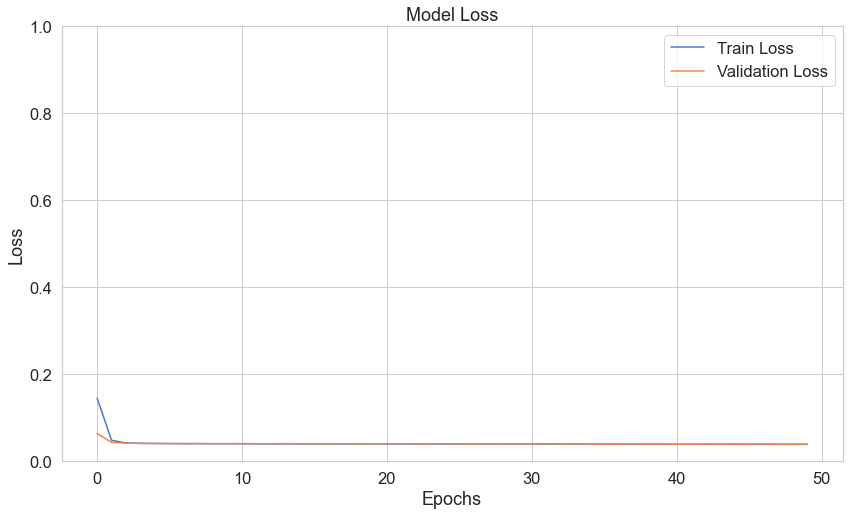

In [32]:
# 평가하기
plt.figure()
plt.plot(range(nb_epochs), history['loss'])
plt.plot(range(nb_epochs), history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right');
plt.ylim([0, 1])
plt.show()

In [22]:
'''
오류 분포표
- 정밀도(Precision)
: 참인데 참이라고 예측한 데이터 / 참이라고 예측한 데이터
: 정상인데 정상이라고 예측한 데이터 / 정상이라고 예측한 데이터
- 재현율(Recall)
: 참인데 참이라고 예측한 데이터 / 실제로 참인 데이터
: 정상인테 정상이라고 예측한 데이터 / 실제로 정상인 데이터
'''
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power((X_test - predictions), 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

539/539 [==============================] - 0s 602us/step


,reconstruction_error,true_class
count,17244.000000,17244.0
mean,0.178130,0.0
std,0.119982,0.0
min,0.002070,0.0
25%,0.088286,0.0
50%,0.177009,0.0
75%,0.255443,0.0
max,0.632334,0.0


Text(0, 0.5, 'data')

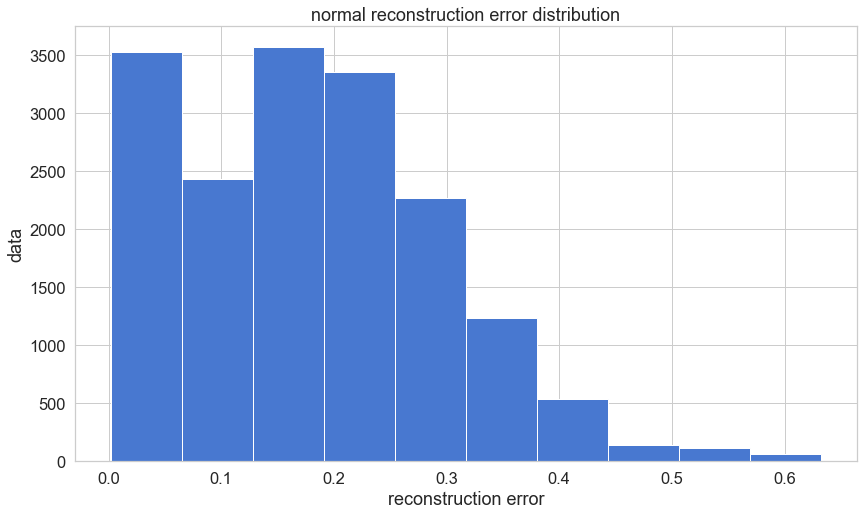

In [23]:
# 정상 거래 데이터들의 재구성 오류 분포
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
ax.set_title('normal reconstruction error distribution')
ax.set_xlabel('reconstruction error')
ax.set_ylabel('data')

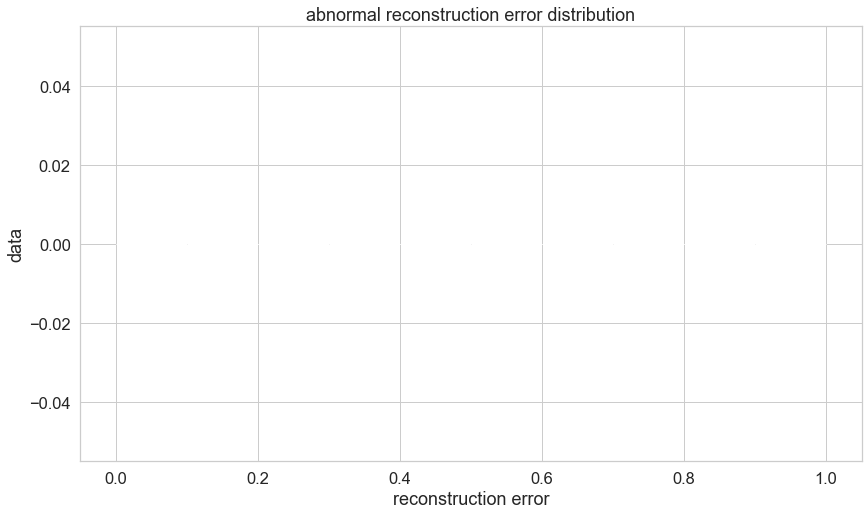

In [26]:
# 이상 거래 데이터들의 재구성 오류 분포
fig = plt.figure()
ax = fig.add_subplot(111)
Abnormal_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(Abnormal_error_df.reconstruction_error.values, bins=10)
ax.set_title('abnormal reconstruction error distribution')
ax.set_xlabel('reconstruction error')
ax.set_ylabel('data')
plt.show();

In [27]:
# ROC 곡선을 통한 평가
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
# ROC 곡선은 이진 분류기(binary classifier)의 성능을 평가하는 유용한 도구이다.
# 굉정히 불균형한 데이터셋을 가지고 있기 때문에 일반적인 경우가 아님
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

C:\Users\박범준\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [28]:
predictions = autoencoder.predict(X_train)
square_error1 = np.power((X_train - predictions), 2)
mse= np.mean(square_error1, axis=1)
# thresholds = np.mean(mse, axis=0)
# thresholds = np.mean(mse,axis=0) + 1.68 * np.var(mse,axis=0)
aver_rmse = np.mean(np.sqrt(mse), axis=0)
thresholds = aver_rmse

plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show();

# Threshold vs precision
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show();

# Threshold vs Recall
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

NameError: name 'X_train2' is not defined

610/610 [==============================] - 0s 704us/step


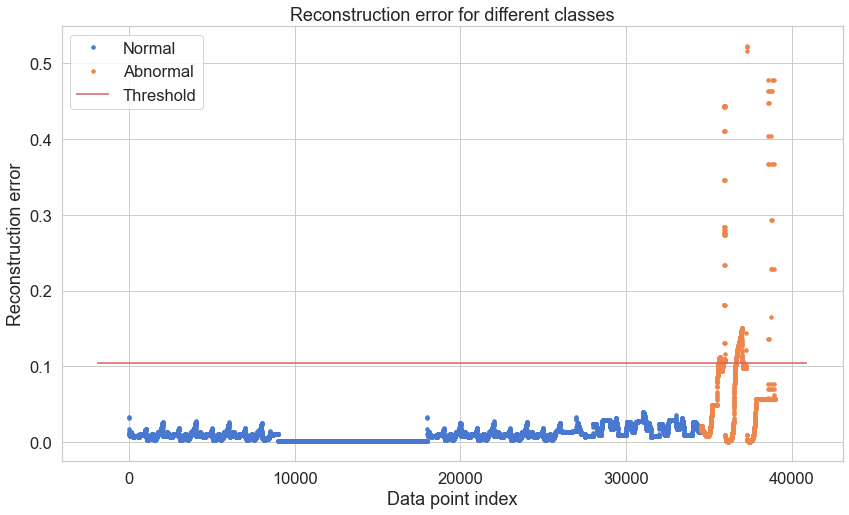

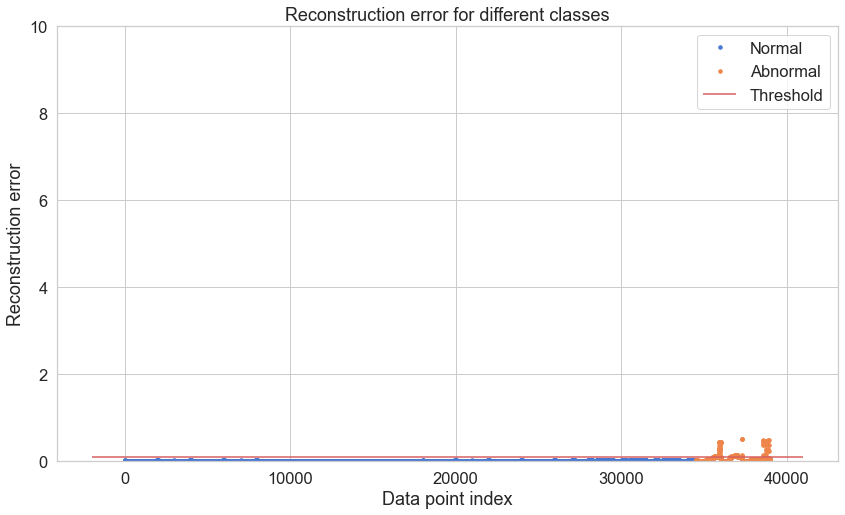

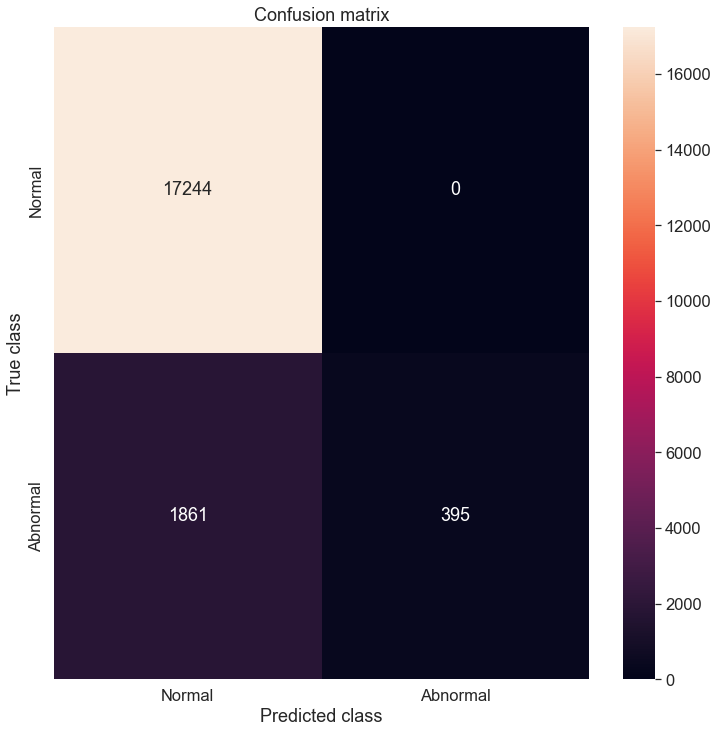

In [17]:
#
predictions = autoencoder.predict(X_train)
square_error1 = np.power((X_train - predictions), 2)
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.hlines(thresholds, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.hlines(thresholds, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim([0, 10])
plt.show();

y_pred = [1 if e > thresholds else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()